### Health Data Science Group Assignment

### Modelling Hospital ward Capacity in Python: A Discrete Event Simulation Study based on Penn et al., 2020
Candidate Numbers: 710038490, 740093003, 740090838

### Overview

The purpose of this project is to use the model developed in Penn et al., (2020) to test if it can be implemented using python and used to simulate a similar NHS facility, or other related facility.  There is value in developing models with sufficient flexibility to allow them to be modified for different purposes, although this must weighed against the simplicity of the model, as increased flexibility can lead to a more complex solution.  

The study described in Penn et al, (2020) initially developed the simulation based on a community hospital rehabilitation ward, and was successfully adapted for application to an Intensive Care Unit (ICU).  In the presented study, we focus on one ward, with female and male patients, where these two groups should be provided beds within areas of the same sex.

The code below has recreated the model from the study according to the following steps:

**Section 1:** Creation of the data structure and core classes

**Section 2**: Simulation processes

**Section 3**: Simulation and Replication Functions (with Custom Parameters)

**Section 4:** Running Multiple Scenarios and Visualizing Results

**Section 5:** Main Execution

Further details are described below for each section.



### ChatGPT

This code was developed through using ChatGPT together with previous outputs from Perplexity generated code.  The prompt used to generate the code is as follows:

ChatGPT o1-model prompt:

Generate a complete Python script that simulates a hospital ward using SimPy, NumPy, Pandas, and Matplotlib. Structure the code with clear section headers and detailed inline comments. Use consistent terminology.

Define a Patient dataclass with attributes: pid (patient identifier), arrival time, gender, group (choose from 5 groups), los hours (length of stay in hours), max wait, waiting time, and bedallocated.

Next, create a WardBay class (with methods can accept(), add patient(), remove patient(), plus occupancy properties) and a HospitalWard class that manages multiple bays and single rooms.

The ward allocation logic:
1. If a free bed exists, allocate to a bay which has the same gender.
2. Otherwise, allocate to an empty bay.
3. Otherwise, allocate to a single room.
4. Otherwise, if a single room is occupied by an opposite-gender patient, try to shuffle that
occupant into a bay (only allow one level of shuffling).
5. Otherwise, the patient waits.

Then, implement simulation processes:
• A patient generator function that uses an exponential interarrival distribution to create patients (assigning each to one of 5 groups and setting attributes, including one that affects los hours).
• A wait in queue function that retries allocation every 4 hours and makes the patient leave if waiting exceeds max wait.
• A treatment process function that simulates the patient’s stay and then calls discharge patient to remove the patient and update metrics.
Then write functions to run one simulation replication (returning metrics like final queue length, average/max waiting time, total discharges, and single room swaps) and to run 20 replications per scenario (e.g., Base, HighArrival, LowArrival, MoreBeds, MoreSingles).

Compile the results in a Pandas DataFrame, generate Matplotlib visualisations comparing
key metrics across scenarios, and save the results to a CSV file.



In [1]:
# Import necessary libraries
import simpy  # For discrete-event simulation
import numpy as np  # For random number generation and numerical operations
import matplotlib.pyplot as plt  # For visualizing results
import pandas as pd  # For data manipulation and analysis
from dataclasses import dataclass  # For creating simple data structures
from typing import List, Dict, Optional  # For type hinting


#### Section 1: Data Structures and Core Classes
This section creates the classes that are required to set up the patient flow through the process.  The following classes have been created below: 

**Patient class**, including patient IDs, gender, length of stay etc

**WardBay class**, setting up the bays that include multiple beds with unique IDs for the bays and a capacity which can be set.  There is an optional gender setting which can be employed in accordance with the parameters.  The parameters defined provide the order in which patients should be allocated to beds within the bays.  The code provides the following methods:

    Method 1: For checking if a bay can accept a patient, based on capacity and gender; 

    Method 2: For adding a patient to a bay, and potentially setting a gender restriction for the bay; 

    Method 3: For removing a patient from a bay, and potentially resetting the gender restriction for the bay if it becomes empty

    Method 4: For counting the number of patients in the bay, which can be used to identify capacity

    Method 5: Following method 4, this method identifies the number of available beds


**HospitalWard class**, which manages multiple bays and single rooms.  This also includes a function that sets out the rules for allocating patients beds within the bays, in accordance with the Penn et al., (2020) study.  It prioritises placing the patient in a bay with the same gender, then an empty bay, then a single room, and finally tries to shuffle existing patients from one bay to another if necessary.



In [2]:

# ==============================================================================
# Section 1: Data Structures and Core Classes
# ==============================================================================

# Define a Patient class to represent individual patients in the simulation
@dataclass
class Patient:
    pid: int  # Unique patient ID
    arrival_time: float  # Time of arrival at the hospital
    gender: str  # Gender of the patient ('male' or 'female')
    group: str  # Group identifier (e.g., "Group1")
    los_hours: float  # Length of stay in hours
    max_wait: float  # Maximum waiting time before leaving
    waiting_time: float = 0.0  # Time spent waiting for a bed
    bed_allocated: bool = False  # Whether the patient has been allocated a bed

# Define a WardBay class to represent a bay with multiple beds
class WardBay:
    def __init__(self, bay_id: int, capacity: int):
        """
        Initialize a WardBay object.

        Parameters:
        - bay_id (int): Unique ID for the bay.
        - capacity (int): Total number of beds in the bay.
        """
        self.bay_id = bay_id  # Unique ID for the bay
        self.capacity = capacity  # Total number of beds in the bay
        self.current_gender: Optional[str] = None  # Gender of patients in the bay (None if empty)
        self.patients: List[Patient] = []  # List of patients currently in the bay

    # Check if the bay can accept a patient based on gender and capacity
    def can_accept(self, p: Patient) -> bool:
        """
        Determine if the bay can accept a patient.

        Parameters:
        - p (Patient): The patient to check.

        Returns:
        - bool: True if the bay can accept the patient, False otherwise.
        """
        if len(self.patients) >= self.capacity:  # Check if the bay is full
            return False
        return (self.current_gender is None) or (self.current_gender == p.gender)  # Check gender compatibility

    # Add a patient to the bay and set the bay's gender if it was empty
    def add_patient(self, p: Patient):
        """
        Add a patient to the bay.

        Parameters:
        - p (Patient): The patient to add.
        """
        self.patients.append(p)
        if self.current_gender is None:  # Set the bay's gender if it was empty
            self.current_gender = p.gender

    # Remove a patient from the bay and reset the bay's gender if it becomes empty
    def remove_patient(self, p: Patient):
        """
        Remove a patient from the bay.

        Parameters:
        - p (Patient): The patient to remove.
        """
        if p in self.patients:
            self.patients.remove(p)
        if len(self.patients) == 0:  # Reset gender if the bay is empty
            self.current_gender = None

    # Property to get the number of occupied beds
    @property
    def n_occupied(self):
        """
        Get the number of occupied beds in the bay.

        Returns:
        - int: Number of occupied beds.
        """
        return len(self.patients)

    # Property to get the number of free beds
    @property
    def n_free(self):
        """
        Get the number of free beds in the bay.

        Returns:
        - int: Number of free beds.
        """
        return self.capacity - len(self.patients)

# Define a HospitalWard class to manage multiple bays and single rooms
class HospitalWard:
    def __init__(self, env: simpy.Environment, num_bays: int, beds_per_bay: int, num_singles: int):
        """
        Initialize a HospitalWard object.

        Parameters:
        - env (simpy.Environment): SimPy environment for the simulation.
        - num_bays (int): Number of multi-bed bays in the ward.
        - beds_per_bay (int): Number of beds in each bay.
        - num_singles (int): Number of single rooms in the ward.
        """
        self.env = env  # SimPy environment for the simulation
        self.bays: List[WardBay] = [WardBay(bay_id=i, capacity=beds_per_bay) for i in range(num_bays)]  # List of bays
        self.single_rooms: List[Optional[Patient]] = [None] * num_singles  # List of single rooms
        self.wait_queue: List[Patient] = []  # Queue of patients waiting for beds
        self.wait_times: Dict[int, float] = {}  # Dictionary to track waiting times for each patient
        self.single_room_swaps: int = 0  # Count of gender-based swaps in single rooms
        self.total_discharges: int = 0  # Total number of discharged patients

    # Attempt to allocate a bed to a patient
    def try_allocate(self, p: Patient, allow_shuffle: bool = True) -> bool:
        """
        Attempt to allocate a bed to a patient.

        Parameters:
        - p (Patient): The patient to allocate a bed for.
        - allow_shuffle (bool): Whether to allow shuffling of single-room occupants.

        Returns:
        - bool: True if a bed was successfully allocated, False otherwise.
        """
        # Try to place the patient in a bay with the same gender
        same_gender_bays = [bay for bay in self.bays if bay.can_accept(p) and bay.current_gender == p.gender]
        if same_gender_bays:
            bay = max(same_gender_bays, key=lambda b: b.n_occupied / b.capacity)  # Choose the most occupied bay
            bay.add_patient(p)
            p.bed_allocated = True
            return True

        # Try to place the patient in an empty bay
        empty_bays = [bay for bay in self.bays if bay.can_accept(p) and bay.current_gender is None]
        if empty_bays:
            bay = empty_bays[0]
            bay.add_patient(p)
            p.bed_allocated = True
            return True

        # Try to place the patient in a single room
        for i in range(len(self.single_rooms)):
            if self.single_rooms[i] is None:  # Check if the single room is empty
                self.single_rooms[i] = p
                p.bed_allocated = True
                return True

        # If allowed, shuffle a single-room occupant of the opposite gender to make space
        if allow_shuffle:
            for i in range(len(self.single_rooms)):
                occupant = self.single_rooms[i]
                if occupant is not None and occupant.gender != p.gender:
                    occupant.bed_allocated = False
                    if self.try_allocate(occupant, allow_shuffle=False):  # Try to reallocate the occupant
                        self.single_rooms[i] = p
                        p.bed_allocated = True
                        self.single_room_swaps += 1  # Increment swap count
                        return True
                    else:
                        occupant.bed_allocated = True  # Restore the occupant's allocation if reallocation fails
        return False


#### Section2: Simulation Processes

The simulation process includes a function for generating the patients at random intervals, allocating them a gender based on a probability (defined later) and allocating them a bed where possible.  A 'wait in queue' function is created for handling those patients that cannot be allocated a bed.  Patients in this group are periodically checked to see if they can be allocated a bed.  Once a maximum wait time is reached they are removed from the queue.  A function is included for simulating a patient's stay in the ward and a separate function for their removal from their bed at the end of the process and update the records.



In [3]:

# ==============================================================================
# Section 2: Simulation Processes
# ==============================================================================

# Generate patients at random intervals and attempt to allocate beds
def patient_generator(env, ward: HospitalWard, group_name: str,
                      mean_iat: float, los_days: float, gender_prob: float,
                      max_wait_hours: float, rng_seed: int = 42):
    """
    Generates patients at random intervals and attempts to allocate beds for them.

    Parameters:
    - env (simpy.Environment): The simulation environment.
    - ward (HospitalWard): The hospital ward where patients are admitted.
    - group_name (str): Identifier for the patient group (e.g., "Group1").
    - mean_iat (float): Mean interarrival time between patients (in hours).
    - los_days (float): Average length of stay for patients (in days).
    - gender_prob (float): Probability of a patient being female (0.0 to 1.0).
    - max_wait_hours (float): Maximum time a patient is willing to wait for a bed (in hours).
    - rng_seed (int): Seed for the random number generator (default is 42).

    This function continuously generates patients, assigns them attributes (e.g., gender, length of stay),
    and attempts to allocate a bed for them. If a bed is not available, the patient is added to the wait queue.
    """
    rng = np.random.default_rng(rng_seed)  # Random number generator for reproducibility
    pid_count = 0  # Patient ID counter to uniquely identify each patient
    while True:
        iat = rng.exponential(mean_iat)  # Generate interarrival time using an exponential distribution
        yield env.timeout(iat)  # Wait for the next patient arrival
        pid_count += 1
        arrival_time = env.now  # Record the current simulation time as the patient's arrival time
        gender = 'female' if rng.random() < gender_prob else 'male'  # Assign gender based on probability
        los_hours = los_days * 24.0  # Convert length of stay from days to hours
        # Create a new Patient object with the generated attributes
        patient = Patient(pid=pid_count, arrival_time=arrival_time,
                          gender=gender, group=group_name,
                          los_hours=los_hours, max_wait=max_wait_hours)
        print(f"[{env.now:.2f}] Patient {patient.pid} (gender={patient.gender}) arrives.")
        # Attempt to allocate a bed for the patient
        allocated = ward.try_allocate(patient)
        if allocated:
            # If a bed is allocated, start the treatment process
            env.process(treatment_process(env, ward, patient))
        else:
            # If no bed is available, add the patient to the wait queue
            patient.waiting_time = env.now
            ward.wait_queue.append(patient)
            # Start the waiting process for the patient
            env.process(wait_in_queue(env, ward, patient))

# Handle patients in the wait queue
def wait_in_queue(env, ward: HospitalWard, p: Patient):
    """
    Handles patients in the wait queue by periodically checking for bed availability.

    Parameters:
    - env (simpy.Environment): The simulation environment.
    - ward (HospitalWard): The hospital ward where patients are waiting.
    - p (Patient): The patient waiting for a bed.

    This function periodically checks if a bed becomes available for the patient.
    If the maximum waiting time is exceeded, the patient is removed from the queue.
    """
    recheck_interval = 4.0  # Interval (in hours) to recheck bed availability
    start_wait = env.now  # Record the time when the patient started waiting
    while True:
        yield env.timeout(recheck_interval)  # Wait for the recheck interval
        if p not in ward.wait_queue:  # Check if the patient has already been removed from the queue
            return
        if (env.now - start_wait) > p.max_wait:  # Check if the maximum waiting time has been exceeded
            ward.wait_queue.remove(p)  # Remove the patient from the queue
            print(f"[{env.now:.2f}] Patient {p.pid} left after waiting {env.now - start_wait:.1f}h.")
            return
        # Attempt to allocate a bed for the patient
        allocated = ward.try_allocate(p)
        if allocated:
            # If a bed is allocated, remove the patient from the queue
            ward.wait_queue.remove(p)
            total_wait = env.now - start_wait  # Calculate the total waiting time
            ward.wait_times[p.pid] = total_wait  # Record the waiting time for the patient
            print(f"[{env.now:.2f}] Patient {p.pid} admitted after waiting {total_wait:.1f}h.")
            # Start the treatment process for the patient
            env.process(treatment_process(env, ward, p))
            return

# Simulate a patient's stay in the ward
def treatment_process(env, ward: HospitalWard, p: Patient):
    """
    Simulates a patient's stay in the hospital ward.

    Parameters:
    - env (simpy.Environment): The simulation environment.
    - ward (HospitalWard): The hospital ward where the patient is admitted.
    - p (Patient): The patient undergoing treatment.

    This function waits for the patient's length of stay (in hours) and then discharges the patient.
    """
    yield env.timeout(p.los_hours)  # Wait for the length of stay
    discharge_patient(ward, p, env.now)  # Discharge the patient after the stay

# Remove a patient from their assigned bed and update metrics
def discharge_patient(ward: HospitalWard, p: Patient, current_time: float):
    """
    Removes a patient from their assigned bed and updates ward metrics.

    Parameters:
    - ward (HospitalWard): The hospital ward where the patient was admitted.
    - p (Patient): The patient being discharged.
    - current_time (float): The current simulation time.

    This function removes the patient from their assigned bay or single room
    and increments the total discharge count for the ward.
    """
    # Check if the patient is in any of the bays
    for bay in ward.bays:
        if p in bay.patients:
            bay.remove_patient(p)
            ward.total_discharges += 1
            print(f"[{current_time:.2f}] Patient {p.pid} discharged from Bay {bay.bay_id}.")
            return
    for i, occupant in enumerate(ward.single_rooms):
        if occupant == p:
            ward.single_rooms[i] = None
            ward.total_discharges += 1
            print(f"[{current_time:.2f}] Patient {p.pid} discharged from Single Room {i}.")
            return

#### Section 3: Simulation and Replication Functions (with Custom Parameters)

This section includes two functions which run and analyse a simulation of the hospital ward.  The first function simulates the operation of the ward and returns key performance metrics which can be used later for assessing different simulation parameters, and to determine which changes could be the most appropriate for the hospital to adopt in different scenarios.  The function first creates the Simpy environment which can manage the simulation of time and events, then initialises the hospital ward based on setup parameters.  The patient generator is then started, to simulate the arrival of patients over time, also taking into account interarrival time, length of stay, gender distribution and maximum waiting time.  The simulation is then run, and key performance metrics are calculated and returned.

The second function runs multiple replicatons of the hospital simulation, which will generate a more robust set of results through repeating the simulation process.  Random seeds are also varied to understand the trends better.  The metrics track performance measures such as waiting times, number of discharges, and gender-based room swaps.


In [4]:
# ==============================================================================
# Section 3: Simulation and Replication Functions (with Custom Parameters)
# ==============================================================================

def run_simulation(replication_time: float, seed: int,
                   mean_iat: float, los_days: float, gender_prob: float,
                   max_wait_hours: float, num_bays: int, beds_per_bay: int, num_singles: int) -> Dict:
    """
    Runs a single replication of the simulation with the given parameters.
    Returns key performance metrics.

    Parameters:
    - replication_time (float): Total time for which the simulation will run (in hours).
    - seed (int): Random seed for reproducibility of random events.
    - mean_iat (float): Mean interarrival time between patients (in hours).
    - los_days (float): Average length of stay for patients (in days).
    - gender_prob (float): Probability of a patient being female (0.0 to 1.0).
    - max_wait_hours (float): Maximum time a patient is willing to wait for a bed (in hours).
    - num_bays (int): Number of multi-bed bays in the hospital ward.
    - beds_per_bay (int): Number of beds in each bay.
    - num_singles (int): Number of single rooms available in the ward.

    Returns:
    - metrics (Dict): A dictionary containing key performance metrics:
        - "FinalQueueLength": Number of patients still in the queue at the end of the simulation.
        - "AverageWaitingTime": Average waiting time for admitted patients (in hours).
        - "MaxWaitingTime": Maximum waiting time experienced by any patient (in hours).
        - "TotalDischarges": Total number of patients discharged during the simulation.
        - "SingleRoomSwaps": Number of gender-based swaps in single rooms.
        - "SimulationTime": Total time the simulation ran (in hours).
    """
    # Create a SimPy environment for the simulation
    env = simpy.Environment()

    # Initialize the hospital ward with the specified number of bays, beds per bay, and single rooms
    ward = HospitalWard(env, num_bays=num_bays, beds_per_bay=beds_per_bay, num_singles=num_singles)

    # Start the patient generator process in the simulation environment
    env.process(patient_generator(env, ward, group_name="Group1",
                                  mean_iat=mean_iat,  # Mean interarrival time
                                  los_days=los_days,  # Length of stay in days
                                  gender_prob=gender_prob,  # Probability of female patients
                                  max_wait_hours=max_wait_hours,  # Maximum waiting time
                                  rng_seed=seed))  # Random seed for reproducibility

    # Run the simulation for the specified replication time
    env.run(until=replication_time)

    # Calculate average waiting time for admitted patients
    avg_wait = np.mean(list(ward.wait_times.values())) if ward.wait_times else 0.0

    # Calculate maximum waiting time experienced by any patient
    max_wait = np.max(list(ward.wait_times.values())) if ward.wait_times else 0.0

    # Collect key performance metrics
    metrics = {
        "FinalQueueLength": len(ward.wait_queue),  # Number of patients still in the queue
        "AverageWaitingTime": avg_wait,  # Average waiting time for admitted patients
        "MaxWaitingTime": max_wait,  # Maximum waiting time experienced by any patient
        "TotalDischarges": ward.total_discharges,  # Total number of patients discharged
        "SingleRoomSwaps": ward.single_room_swaps,  # Number of gender-based swaps in single rooms
        "SimulationTime": replication_time  # Total simulation time
    }

    # Return the collected metrics
    return metrics

def run_replications(num_replications: int, replication_time: float,
                     mean_iat: float, los_days: float, gender_prob: float,
                     max_wait_hours: float, num_bays: int, beds_per_bay: int, num_singles: int) -> pd.DataFrame:
    """
    Runs multiple replications for a given scenario and returns a DataFrame of metrics.

    Parameters:
    - num_replications (int): Number of replications to run for the scenario.
    - replication_time (float): Total time for which each simulation will run (in hours).
    - mean_iat (float): Mean interarrival time between patients (in hours).
    - los_days (float): Average length of stay for patients (in days).
    - gender_prob (float): Probability of a patient being female (0.0 to 1.0).
    - max_wait_hours (float): Maximum time a patient is willing to wait for a bed (in hours).
    - num_bays (int): Number of multi-bed bays in the hospital ward.
    - beds_per_bay (int): Number of beds in each bay.
    - num_singles (int): Number of single rooms available in the ward.

    Returns:
    - df (pd.DataFrame): A DataFrame containing the performance metrics for each replication.
        Columns include:
        - "FinalQueueLength": Number of patients still in the queue at the end of the simulation.
        - "AverageWaitingTime": Average waiting time for admitted patients (in hours).
        - "MaxWaitingTime": Maximum waiting time experienced by any patient (in hours).
        - "TotalDischarges": Total number of patients discharged during the simulation.
        - "SingleRoomSwaps": Number of gender-based swaps in single rooms.
        - "SimulationTime": Total time the simulation ran (in hours).
        - "Replication": Replication number (1 to num_replications).
    """
    # Initialize an empty list to store metrics for all replications
    all_metrics = []

    # Loop through the number of replications
    for rep in range(num_replications):
        # Generate a unique random seed for each replication to ensure variability
        seed = 1000 + rep

        # Run a single replication of the simulation with the specified parameters
        metrics = run_simulation(replication_time, seed,
                                 mean_iat, los_days, gender_prob,
                                 max_wait_hours, num_bays, beds_per_bay, num_singles)

        # Add the replication number to the metrics
        metrics["Replication"] = rep + 1

        # Append the metrics to the list
        all_metrics.append(metrics)

    # Convert the list of metrics into a Pandas DataFrame for easier analysis
    df = pd.DataFrame(all_metrics)

    # Return the DataFrame containing metrics for all replications
    return df

#### Section 4: Running Multiple Scenarios and Visualising Results

This section includes the different scenarios that were assessed with the model.  Different parameters were tested, initially starting with the Base version, against which other scenarios can be compared.  The base model, taken from the study in Penn et al., (2020) includes Interarrival time of 4.0, length of stay of 3.0 (days), 5 bays, 3 beds per bay, and no single bays and a maximum wait of 36 hours.

Other scenarios tested were the following:

**1. High Arrival** - by reducing the interarrival time a higher rate of arrivals is simulated.  The Interarrival is set to 2.0 and a single bed is introduced while other parameters remain the same as the base.

**2. Low Arrival** - by increasing the interarrival time to 6.0 a lower rate of arrivals is simulated and a single bed is introduced. Other parameters remain the same as the base.

**3. More beds** - the number of beds is increased by increasing the number of bays from 5 to 6.  This provides 3 additional beds to the simulation.

**4. More Singles** - the number of single bays is increased from 1 to 2.

**5. High Arrival with more beds** - the number of beds per bay is increased to 5, and combined with the high arrival rate.  This tests whether increasing the number of beds per bay can mitigate the impact of higher arrival rates.

**6. High Arrival with more bays** - the number of bays is increased to 6 (which also increases the number of beds), and combined with the high arrival rate.  This tests whether increasing the number of bays can reduce waiting times and queue lengths.

**7. High Arrival with more bays 2** - further increasing the number bays to 7 (which also increases the number of beds), and combined with the high arrival rate.

**8. High Arrivals with more single beds** - the number of single beds is increased to 5 and combined with the high arrival rate.  This tests whether adding more single rooms can help manage faster arrival rates.

The changes are made to explore the trade-offs between different configurations to optimise performance metrics.

A function follows this to provide mean and standard deviation for each metric and a visualisation of the outputs from each of these scenarios.



In [5]:
# ==============================================================================
# Section 4: Running Multiple Scenarios and Visualising Results
# ==============================================================================

def run_scenarios():
    """
    Runs multiple scenarios with different parameter configurations and returns the results.
    
    Each scenario represents a different configuration of hospital ward parameters, such as
    arrival rates, number of beds, and single rooms. The function runs multiple replications
    for each scenario and collects the results into a single DataFrame.

    Returns:
    - all_results (pd.DataFrame): A DataFrame containing the results of all scenarios and replications.
    """
    # Define a list of scenarios with different parameters.
    # Each dictionary represents a scenario with specific parameter values.
    scenarios = [
        {"scenario_id": "Base", "mean_iat": 4.0, "los_days": 3.0, "num_bays": 5, "beds_per_bay": 3, "num_singles": 0, "max_wait_hours": 36.0},
        {"scenario_id": "HighArrival", "mean_iat": 2.0, "los_days": 3.0, "num_bays": 5, "beds_per_bay": 3, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "LowArrival", "mean_iat": 6.0, "los_days": 3.0, "num_bays": 5, "beds_per_bay": 3, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "MoreBeds", "mean_iat": 4.0, "los_days": 3.0, "num_bays": 6, "beds_per_bay": 3, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "MoreSingles", "mean_iat": 4.0, "los_days": 3.0, "num_bays": 5, "beds_per_bay": 3, "num_singles": 2, "max_wait_hours": 36.0},
        {"scenario_id": "HA_M_Beds", "mean_iat": 2.0, "los_days": 3.0, "num_bays": 5, "beds_per_bay": 5, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "HA_M_Bays", "mean_iat": 2.0, "los_days": 3.0, "num_bays": 6, "beds_per_bay": 3, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "HA_M_Bays2", "mean_iat": 2.0, "los_days": 3.0, "num_bays": 7, "beds_per_bay": 3, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "HA_M_Singles", "mean_iat": 2.0, "los_days": 3.0, "num_bays": 5, "beds_per_bay": 3, "num_singles": 5, "max_wait_hours": 36.0}
    ]

    replication_time = 300  # Total simulation time for each replication (in hours).
    num_replications = 30   # Number of replications to run for each scenario.

    # Initialize an empty list to store results for all scenarios.
   
    scenario_results = []

    # Loop through each scenario and run the specified number of replications.
    for scen in scenarios:
        print(f"\nRunning scenario: {scen['scenario_id']}")  # Log the current scenario being run.
        
        # Run multiple replications for the current scenario.
        df = run_replications(num_replications, replication_time,
                              mean_iat=scen["mean_iat"],
                              los_days=scen["los_days"],
                              gender_prob=0.66,  # Fixed gender probability for all scenarios, 66% female as per the study
                              max_wait_hours=scen["max_wait_hours"],
                              num_bays=scen["num_bays"],
                              beds_per_bay=scen["beds_per_bay"],
                              num_singles=scen["num_singles"])
        
        # Add the scenario identifier to each row of the results DataFrame.
        df["Scenario"] = scen["scenario_id"]
        
        # Append the results for the current scenario to the list.
        scenario_results.append(df)
    
    # Combine the results of all scenarios into a single DataFrame.
    all_results = pd.concat(scenario_results, ignore_index=True)
    
    # Return the combined results.
    return all_results

def visualize_scenario_results(df: pd.DataFrame):
    """
    Generates visualizations comparing the results of different scenarios.

    Parameters:
    - df (pd.DataFrame): A DataFrame containing the results of all scenarios and replications.
    """
    # Group the results by scenario and calculate summary statistics (mean and standard deviation).
    summary = df.groupby("Scenario").agg({
        "AverageWaitingTime": ["mean", "std"],  # Average waiting time and its standard deviation.
        "FinalQueueLength": ["mean", "std"],  # Final queue length and its standard deviation.
        "TotalDischarges": ["mean", "std"],  # Total discharges and its standard deviation.
        "SingleRoomSwaps": ["mean", "std"]  # Single room swaps and its standard deviation.
    })
    
    # Flatten the multi-level column names for easier access.
    summary.columns = ["_".join(col).strip() for col in summary.columns.values]
    summary.reset_index(inplace=True)
    
    # Print the summary statistics for each scenario.
    print("\n--- Summary Statistics per Scenario ---")
    print(summary.to_string(index=False))
    
    # Visualization 1: Bar chart of Average Waiting Time per Scenario.
    plt.figure(figsize=(14, 8))
    plt.bar(summary["Scenario"], summary["AverageWaitingTime_mean"], yerr=summary["AverageWaitingTime_std"],
            capsize=5, color="skyblue")
    plt.xlabel("Scenario")
    plt.ylabel("Average Waiting Time (hours)")
    plt.title("Average Waiting Time by Scenario")
    plt.show()
    
    # Visualization 2: Bar chart of Final Queue Length per Scenario.
    plt.figure(figsize=(14, 8))
    plt.bar(summary["Scenario"], summary["FinalQueueLength_mean"], yerr=summary["FinalQueueLength_std"],
            capsize=5, color="lightgreen")
    plt.xlabel("Scenario")
    plt.ylabel("Final Queue Length")
    plt.title("Final Queue Length by Scenario")
    plt.show()
    
    # Visualization 3: Bar chart of Total Discharges per Scenario.
    plt.figure(figsize=(14, 8))
    plt.bar(summary["Scenario"], summary["TotalDischarges_mean"], yerr=summary["TotalDischarges_std"],
            capsize=5, color="salmon")
    plt.xlabel("Scenario")
    plt.ylabel("Total Discharges")
    plt.title("Total Discharges by Scenario")
    plt.show()
    
    # Visualization 4: Bar chart of Single Room Swaps per Scenario.
    plt.figure(figsize=(14, 8))
    plt.bar(summary["Scenario"], summary["SingleRoomSwaps_mean"], yerr=summary["SingleRoomSwaps_std"],
            capsize=5, color="violet")
    plt.xlabel("Scenario")
    plt.ylabel("Single Room Swaps")
    plt.title("Single Room Swaps by Scenario")
    plt.show()

#### Section 5: Main Execution

This section provides a function for running multiple simulation scenarios, printing the raw simulation results for review, visualising the results to analyse the performance of different scenarios.  Results are saved to a CSV file.


Running scenario: Base
[5.15] Patient 1 (gender=female) arrives.
[11.53] Patient 2 (gender=female) arrives.
[17.30] Patient 3 (gender=female) arrives.
[20.41] Patient 4 (gender=male) arrives.
[23.90] Patient 5 (gender=male) arrives.
[34.81] Patient 6 (gender=female) arrives.
[37.21] Patient 7 (gender=male) arrives.
[39.09] Patient 8 (gender=female) arrives.
[39.66] Patient 9 (gender=female) arrives.
[41.94] Patient 10 (gender=male) arrives.
[46.40] Patient 11 (gender=female) arrives.
[46.69] Patient 12 (gender=female) arrives.
[47.28] Patient 13 (gender=female) arrives.
[49.05] Patient 14 (gender=male) arrives.
[52.53] Patient 15 (gender=female) arrives.
[57.14] Patient 16 (gender=male) arrives.
[58.25] Patient 17 (gender=female) arrives.
[59.74] Patient 18 (gender=female) arrives.
[77.15] Patient 1 discharged from Bay 0.
[78.05] Patient 19 (gender=female) arrives.
[81.62] Patient 20 (gender=female) arrives.
[81.64] Patient 21 (gender=female) arrives.
[82.24] Patient 22 (gender=female

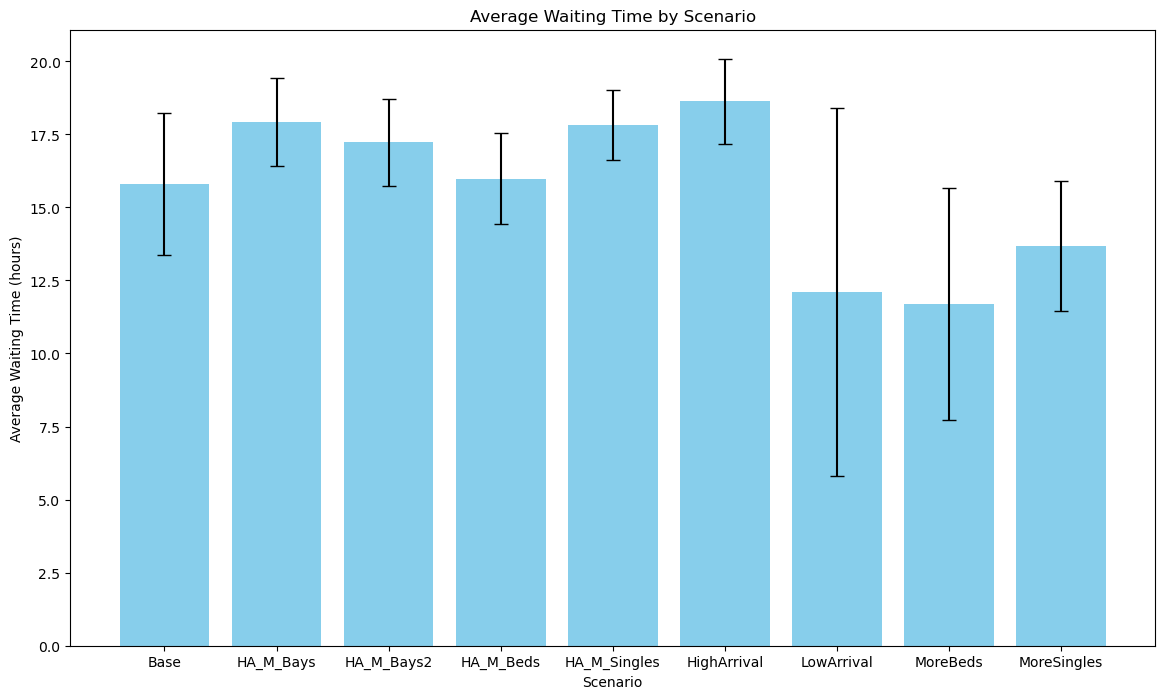

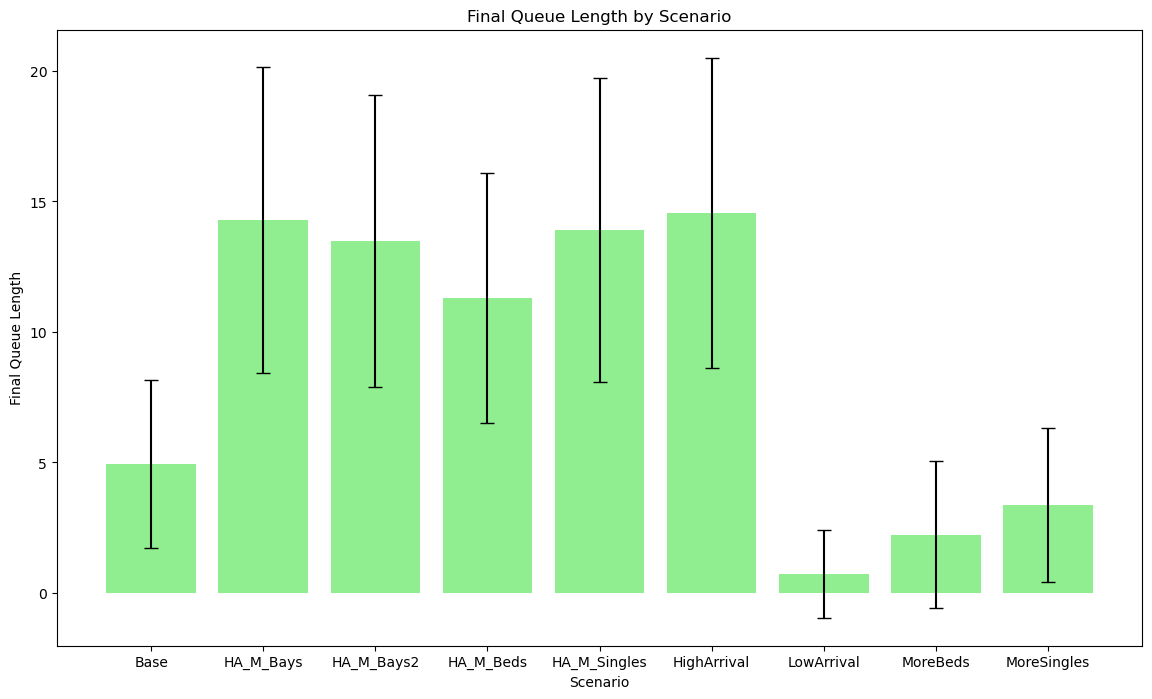

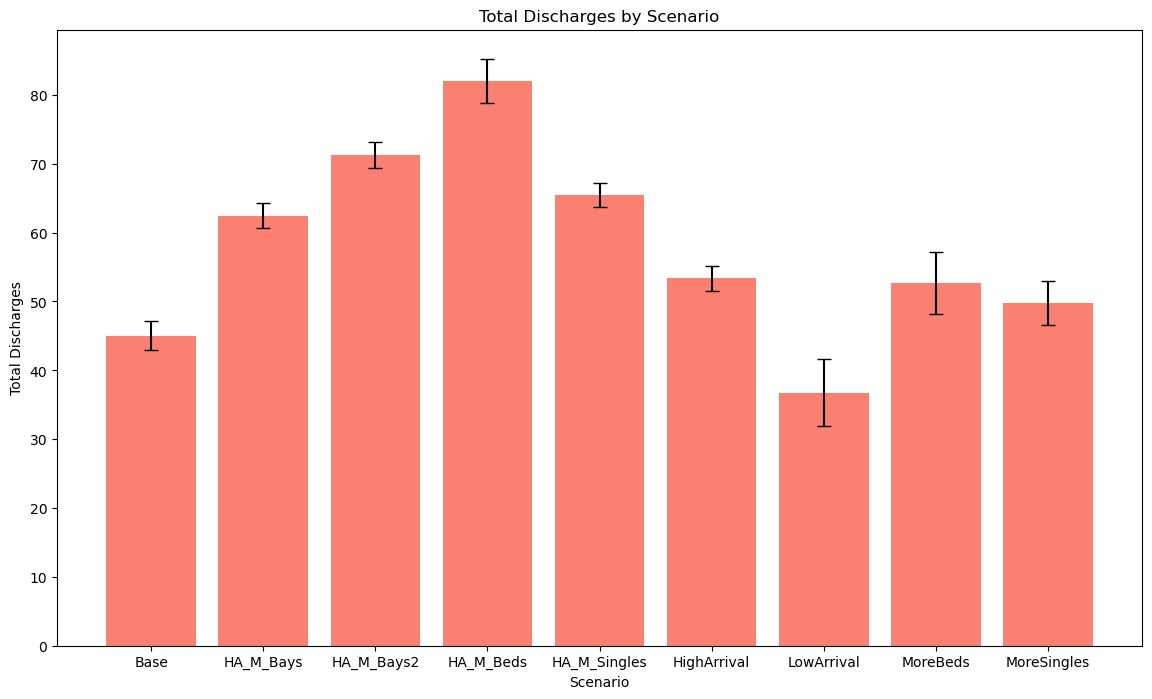

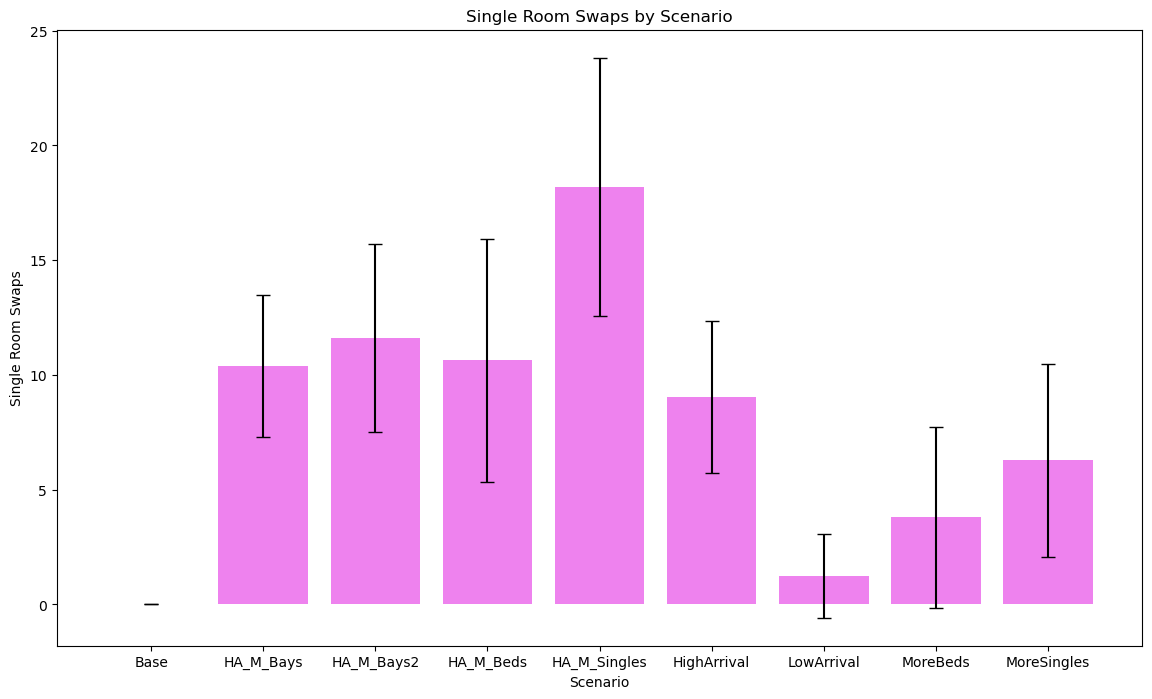


Results saved to 'simulation_results.csv'.


In [6]:
# ==============================================================================
# Section 5: Main Execution
# ==============================================================================

def main():
    """
    Main function to execute the simulation workflow.
    
    This function orchestrates the execution of all scenarios, visualizes the results,
    and optionally saves the results to a CSV file for further analysis or reporting.
    """
    # Step 1: Run all defined scenarios and collect the results.
    # The `run_scenarios` function executes multiple scenarios with different configurations
    # and returns a DataFrame containing the results of all replications for each scenario.
    results_df = run_scenarios()
    
    # Step 2: Print the raw results for each replication.
    # This provides a detailed view of the simulation outcomes for debugging or analysis.
    print("\n--- Raw Simulation Results ---")
    print(results_df.to_string(index=False))  # Print the DataFrame without the index for better readability.
    
    # Step 3: Visualize the results.
    # The `visualize_scenario_results` function generates summary statistics and creates
    # visualizations (e.g., bar charts) to compare the performance of different scenarios.
    visualize_scenario_results(results_df)
    
    # Step 4: Save the results to a CSV file.
    # This step is optional but useful for including the results in reports or further analysis.
    # The results are saved to a file named "simulation_results.csv" in the current working directory.
    results_df.to_csv("simulation_results.csv", index=False)
    print("\nResults saved to 'simulation_results.csv'.")  # Notify the user that the file has been saved.

# Entry point for the script.
# This ensures that the `main` function is executed only when the script is run directly,
# and not when it is imported as a module in another script.
if __name__ == '__main__':
    main()